In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from src.model import ToyNN
from src.generate_data import generate_batch
from src.vis import draw_mini_plots

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Задание

Воспроизвести статью [Antropic](https://transformer-circuits.pub/2023/toy-double-descent/index.html) о двойном спуске и суперпозиции.

Кратко:
- Изначально модель работает в режиме запоминания. Она запоминает высокоразмерные данные в виде отдельных точек в состоянии суперпозиции. В этом случае мы получаем маленький лосс на трейне и большой на тесте.
- С другой стороны модель может работать в режиме обобщения. В этом случае модель обобщает признаки водит их в состоянии суперпозиции. В этом случае имеем низкий лосс как на трейне так и на тесте.
- Между режимами запомпинания (мемоизации) и обобщения (генерализации) происходит скачок значения лосса, который и определяет границу перехода между ними.

Предлагается реализовать игрушечную модель (см. `/src/model.py`)

В статье утверждается, что модель должна находиться в режиме мемоизации в случае, когда размер обучающего набора меньше количества признаков, и в режиме генерализации, когда размер набора больше числа признаков.

### Параметры эксперимента

На вход модели подаются векторы признаков размерностью $n=10000$, отдельным признакам значения проставляются в вероятностью $S=0.001$, $\vert\vert x \vert\vert = 1$

#### Параметры обучения

В качестве оптимизатора берется $AdamW$, с величиной регуляризации $l_{2 reg}=10^{-2}$. Количество шагов обучения $50000$. Прогрев занимает $2500$ шагов $lr \in [0, 10^{-3}]$, затем по косинусу убывает до $0$. На каждом шаге обучения используется весь заготовленный батч с данными.


Визуализация признаков и скрытых состояний на малых режимах данных

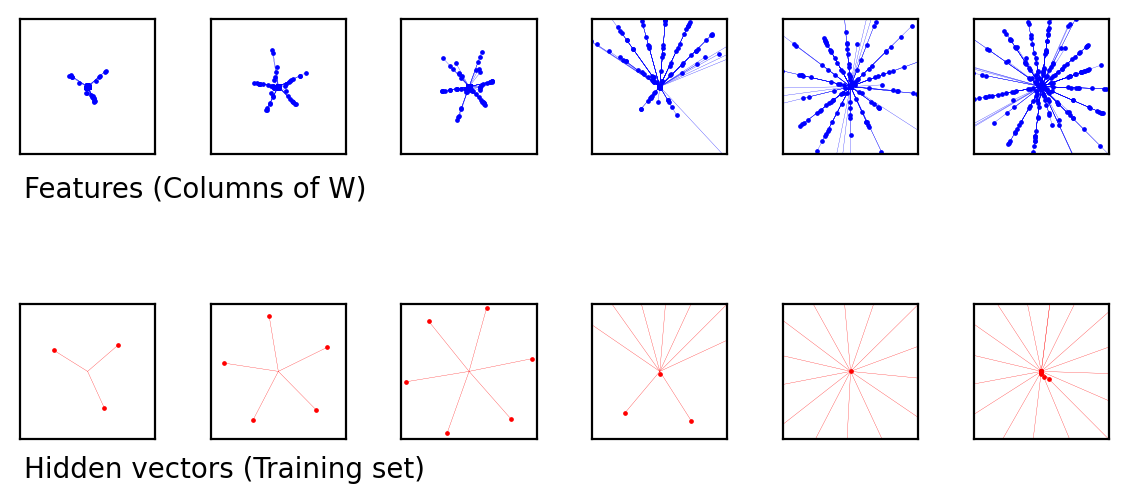

In [9]:
fig, _ = draw_mini_plots([3, 5, 6, 10, 15, 30])

fig.text(0.05, 0.55, 'Features (Columns of W)', va='center', rotation='horizontal')
fig.text(0.05, 0.20, 'Hidden vectors (Training set)', va='center', rotation='horizontal')

plt.show()

Признаки

In [56]:
T = [3, 5, 6, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]

test_losses = []
test_hiddens = []
criterion = nn.MSELoss()

for i, t in tqdm(enumerate(T)):

    checkpoint = torch.load(f'../c'
                            f'heckpoints/checkpoint_{t}.pth', weights_only=False)
    model = ToyNN(input_dim=10_000, hidden_dim=2)
    model.load_state_dict(checkpoint['model'])

    test_batch = generate_batch(
        n_batch=1000,
        n_features=10_000,
        sparsity_prob=0.999,
    )

    model.eval()
    with torch.inference_mode():
        output, hiddens = model(test_batch)
        test_loss = criterion(output, test_batch)
        test_losses.append(test_loss.item())
        test_hiddens.append(hiddens)

17it [00:01, 14.27it/s]


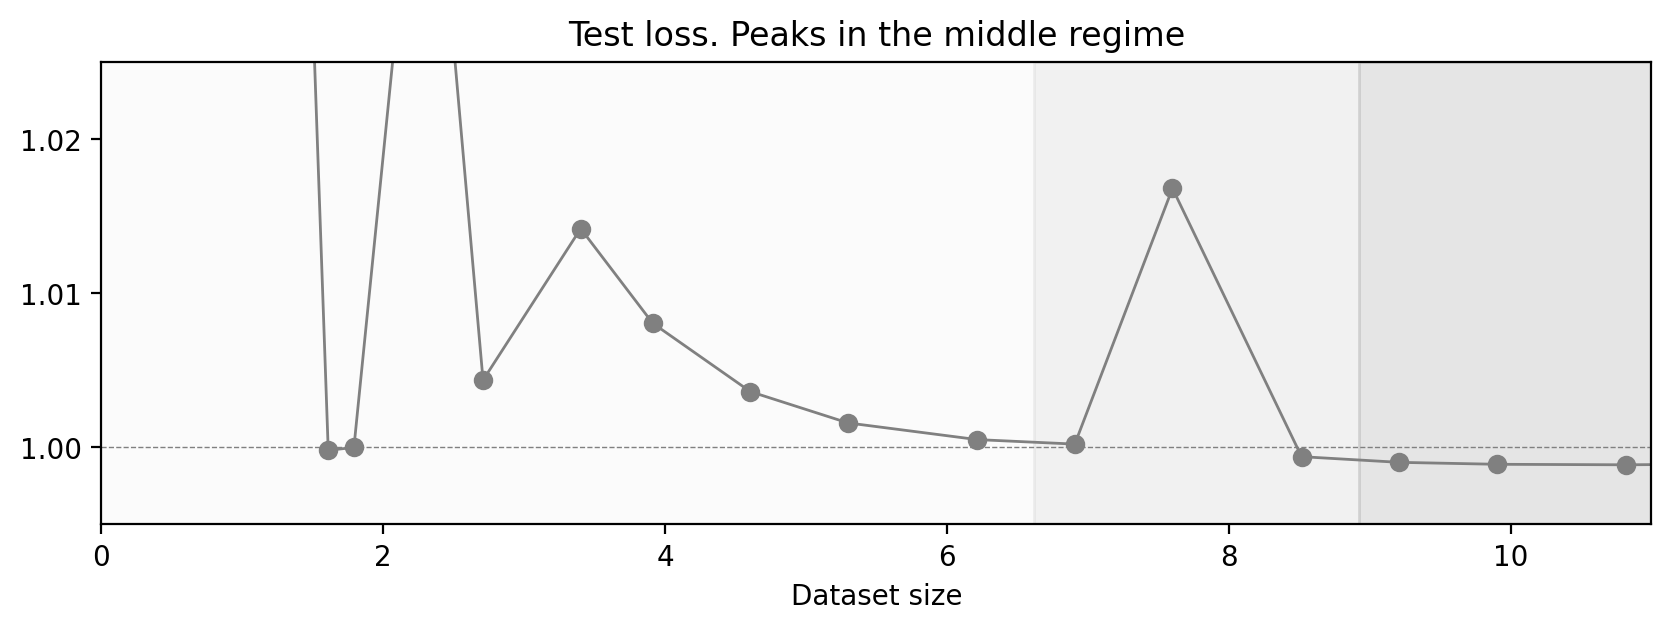

In [65]:
plt.figure(figsize=(10, 3))
plt.plot(np.log(T), np.array(test_losses) * 10_000, marker='o', linewidth=1, color='gray')

plt.yticks([1.0, 1.01, 1.02])
plt.ylim([0.995, 1.025])
plt.xlim([0, 11])
plt.xlabel("Dataset size")
plt.title("Test loss. Peaks in the middle regime")

plt.axvspan(0, np.log(750), color='whitesmoke', alpha=0.3, label='Small Dataset')
plt.axvspan(np.log(750), np.log(7500), color='lightgray', alpha=0.3, label='Small Dataset')
plt.axvspan(np.log(7500), np.log(110000), color='darkgray', alpha=0.3, label='Memorizing regime')

plt.axhline(y=1, color='grey', linestyle='--', linewidth=0.5)

plt.show()

ConversionError: Failed to convert value(s) to axis units: 'Dataset size'

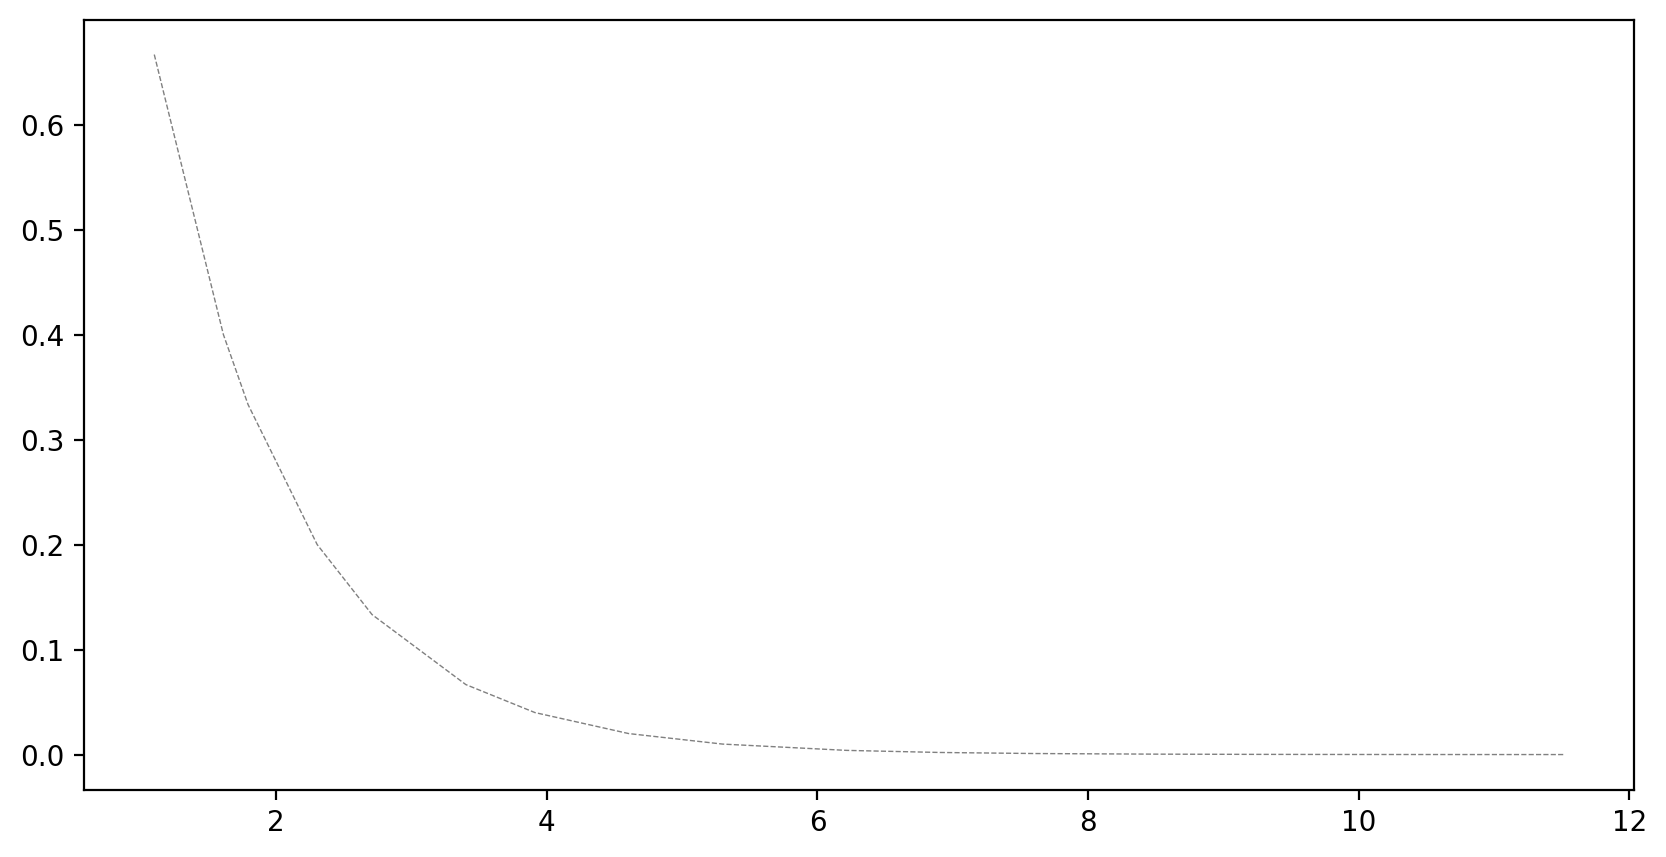

In [73]:
plt.figure(figsize=(10, 5))

plt.plot(np.log(T), [2 / t for t in T], linestyle='--', linewidth=0.5, color='gray')

plt.xticks("Dataset size")

plt.ylim([-0.1, 0.9])

plt.show()

In [75]:
import os

w_norms = []
b_norms = []

for files, _, file_names in os.walk("../checkpoints"):
    for file_name in file_names:
        file_path = os.path.join(files, file_name)
        model = ToyNN(input_dim=10_000, hidden_dim=2)
        checkpoint = torch.load(file_path, weights_only=False)
        model.load_state_dict(checkpoint["model"])
        w_norms.append(model.W.norm(p='fro').cpu().detach().item())
        b_norms.append(model.b.norm(p='fro').cpu().detach().item())

In [76]:
import math

math.sqrt(5)

2.23606797749979

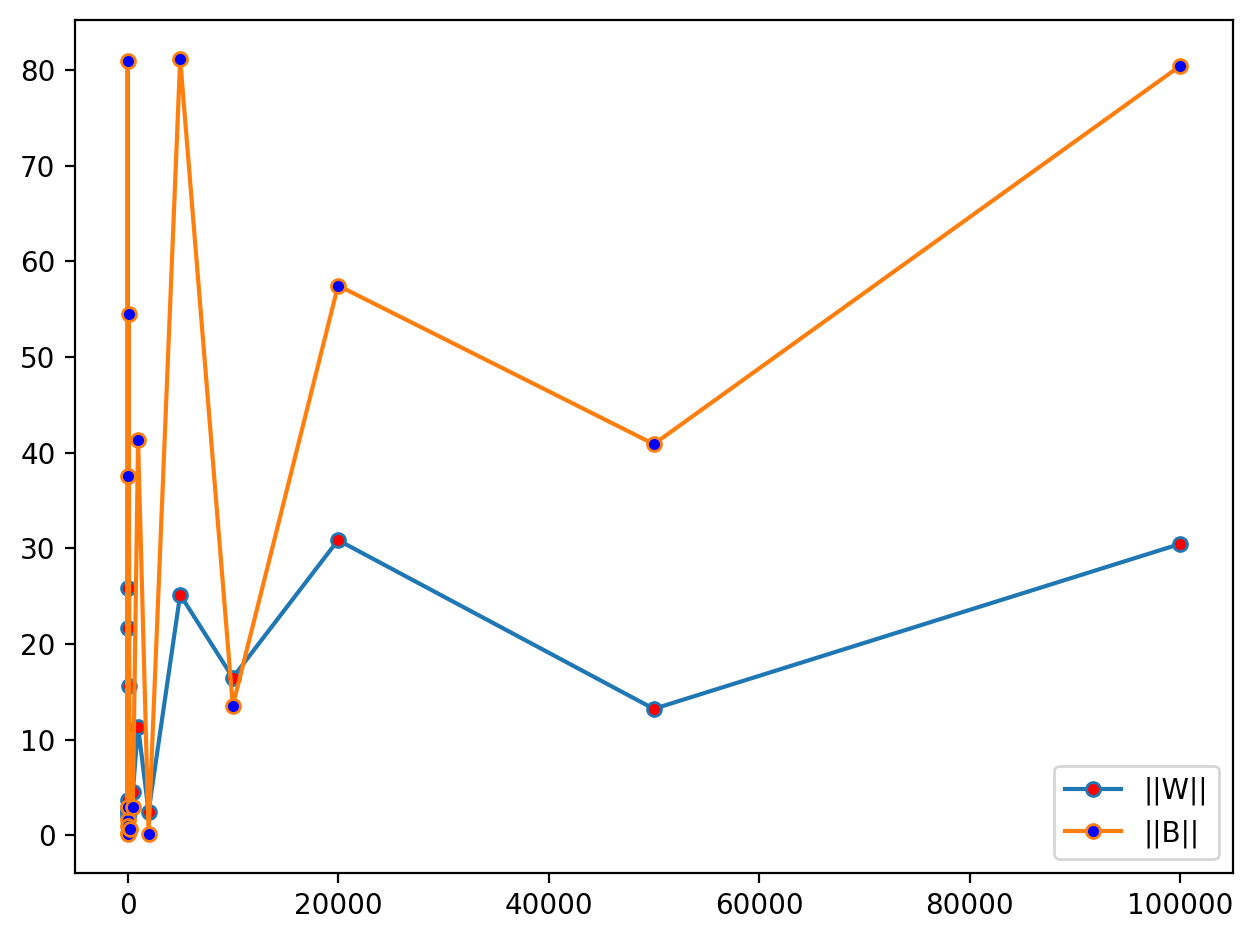

In [78]:
plt.plot(T, w_norms, marker='o', markerfacecolor='r', markersize=5, label='||W||')
plt.plot(T, b_norms, marker='o', markerfacecolor='b', markersize=5, label='||B||')

plt.tight_layout()
plt.legend()

15it [00:43,  2.87s/it]


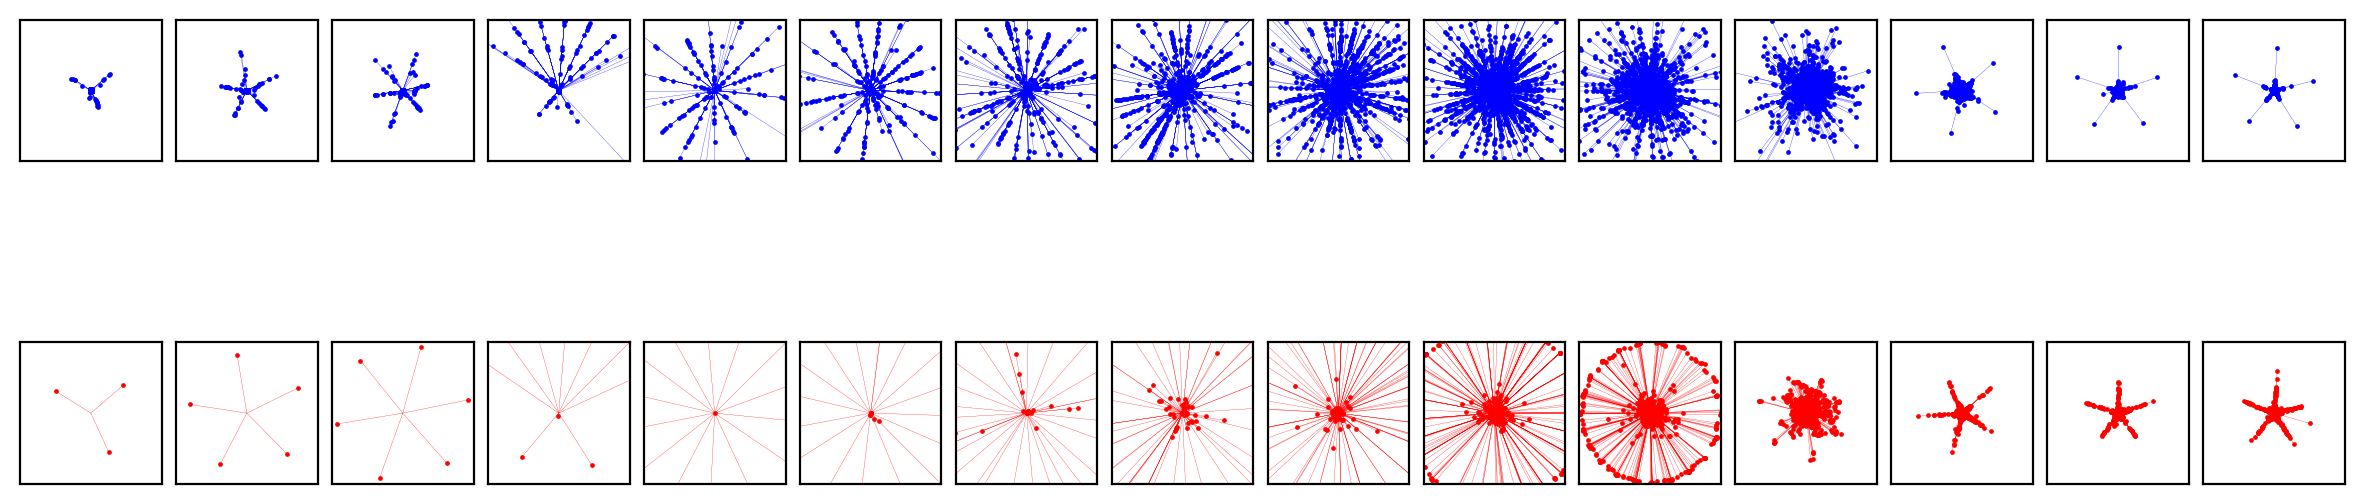

In [35]:
def _draw_in_ax(ax, array_2d: np.ndarray, color: str) -> None:
    ax.set_aspect('equal')
    ax.scatter(array_2d[:, 0], array_2d[:, 1], c=color, s=0.5)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xticks([])
    ax.set_yticks([])

    for i in range(len(array_2d)):
        ax.plot([array_2d[i, 0], 0], [array_2d[i, 1], 0], color=color, linewidth=0.1)

T = [3, 5, 6, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
# T = [3, 5, 6]

fig, axs = plt.subplots(2, len(T), figsize=(len(T), 4))

for i, t in tqdm(enumerate(T)):
    checkpoint = torch.load(f'../checkpoints/checkpoint_{t}.pth', weights_only=False)
    model = ToyNN(input_dim=10_000, hidden_dim=2)
    model.load_state_dict(checkpoint['model'])

    features = model.W.cpu().detach().numpy()
    hiddens = checkpoint['hiddens']
    loss = checkpoint['loss']

    column = axs[:, i]

    _draw_in_ax(column[0], features, 'blue')
    _draw_in_ax(column[1], hiddens, 'red')

# fig.text(0.04, 0.5, 'Features\n(columns of W)', va='center', rotation='horizontal', fontsize=12)
# fig.text(0.04, 0.25, 'Training set\nHidden vectors', va='center', rotation='horizontal', fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()